In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils

import process_data
import config
import network
import net_local

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [4]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [27]:
selected_indice = [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       285, 286, 287]

In [28]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]
n_100307_sub = n_all_100307[:,selected_indice]

big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(76, 3)


In [29]:
net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub, device)
state_dict = torch.load("/Users/weiwenhua/UG_Project_Remote/5g-m/local-02-retrain/model_eded8f75-8557-4d13-b894-045554521f47.pt", map_location=torch.device('cpu'))
net.load_state_dict(state_dict)
net.eval()

# net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# state_dict = torch.load("/Users/weiwenhua/UG_Project_Local/model.pt")
# net.load_state_dict(state_dict)
# net.eval()

# net = net_local.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
# net.load_state_dict(torch.load("/Users/weiwenhua/UG_Project_Local/model_4822b959-724c-4715-9539-18e3d9eab37b.pt"))
# net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=76, out_features=76, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=76, out_features=76, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=76, out_features=76, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=76, out_features=76, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=76, out_features=76, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=76, out_features=76, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=76, out_features=5, bias=True)
  )
)

In [30]:
with torch.no_grad():
    X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

## Parameter Maps -Subsampling

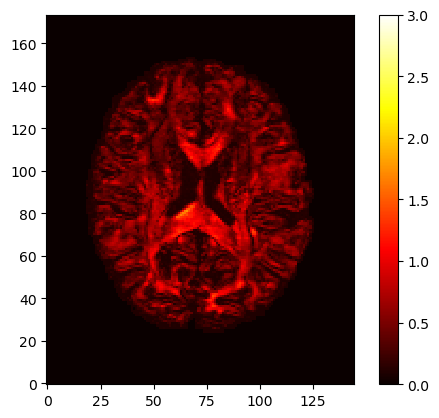

In [31]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

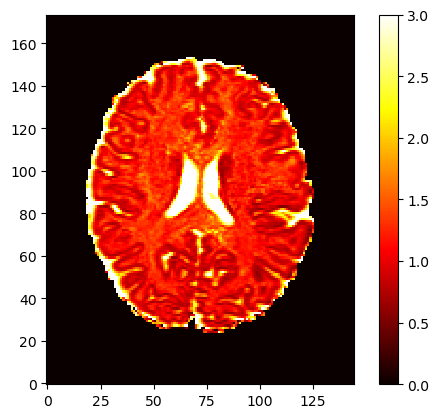

In [32]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

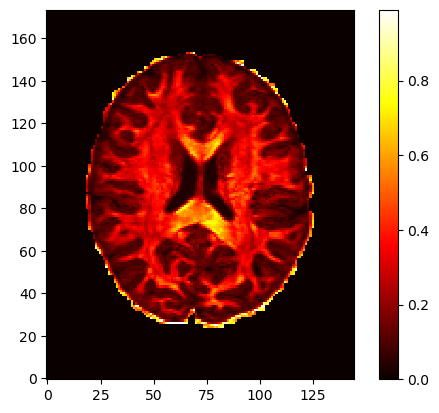

In [33]:
volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

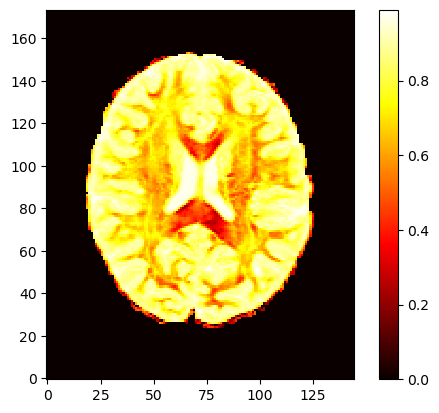

In [34]:
volume_1_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred, (145, 174, 145))
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


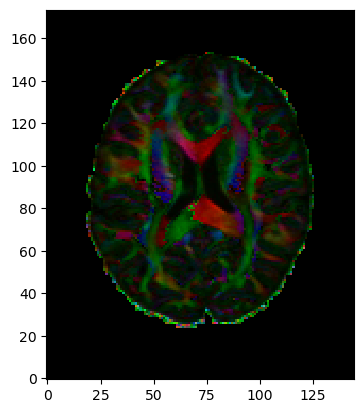

In [35]:
mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307 = np.copy(mask_for_mu)
mu_cart_100307_pred_cp = np.copy(mu_cart_100307_pred.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307[index[0], index[1]] = mu_cart_100307_pred_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped = resume_mu_100307.reshape((145, 174, 145, 3))

volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
volume_0_100307_slice = volume_0_100307_pred_3d[:,:,70]
r = np.repeat(volume_0_100307_slice[:, :, np.newaxis], 3, axis=2)
dir = mu_100307_reshaped[:,:,70,:] * r

plt.imshow(np.rot90(dir, 3), origin='lower', interpolation='nearest')

## Golden STD

In [36]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [37]:
net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307, device)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_golden_std_retrain_trainset.pt"))
net_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [38]:
with torch.no_grad():
    X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [39]:
lambda_par_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_gstd, (145, 174, 145))
lambda_iso_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred_gstd, (145, 174, 145))
volume_0_100307_pred_gstd_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred_gstd, (145, 174, 145))

In [53]:
print(volume_0_100307_pred_gstd.shape)
print(len(np.where(volume_0_100307_pred_gstd >= 0.5)[0]))

torch.Size([740145, 1])
41344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


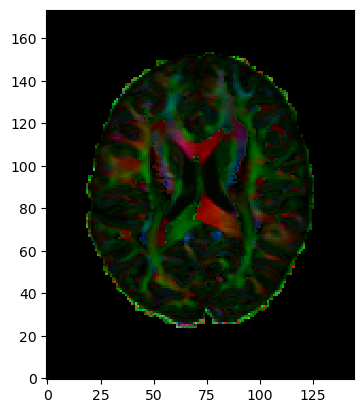

In [40]:
# mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
# no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307_gstd = np.copy(mask_for_mu)
mu_cart_100307_pred_gstd_cp = np.copy(mu_cart_100307_pred_gstd.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307_gstd[index[0], index[1]] = mu_cart_100307_pred_gstd_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped_gstd = resume_mu_100307_gstd.reshape((145, 174, 145, 3))

volume_0_100307_gstd_slice = volume_0_100307_pred_gstd_3d[:,:,70]
r_gstd = np.repeat(volume_0_100307_gstd_slice[:, :, np.newaxis], 3, axis=2)
dir_map_gstd = mu_100307_reshaped_gstd[:,:,70,:] * r_gstd

plt.imshow(np.rot90(dir_map_gstd, 3), origin='lower', interpolation='nearest')

# Parameters Eval

In [41]:
mse = torch.nn.MSELoss(reduction='mean')

In [42]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0061)
tensor(0.0161)
tensor(0.0004)
tensor(0.0004)


In [43]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(mu_cart_100307_pred_gstd, mu_cart_100307_pred)
print(output)

tensor([0.9654, 0.9909, 0.9807,  ..., 0.6790, 0.8342, 0.0220])


(array([ 16242.,   4856.,   4593.,   5227.,   6579.,   8621.,  13121.,
         22538.,  51130., 607238.]),
 array([-9.99999702e-01, -7.99999714e-01, -5.99999785e-01, -3.99999797e-01,
        -1.99999824e-01,  1.49011612e-07,  2.00000122e-01,  4.00000095e-01,
         6.00000083e-01,  8.00000012e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

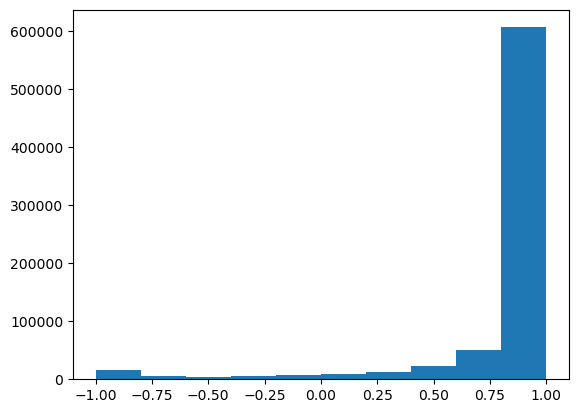

In [44]:
plt.hist(output.detach().numpy())

# Average

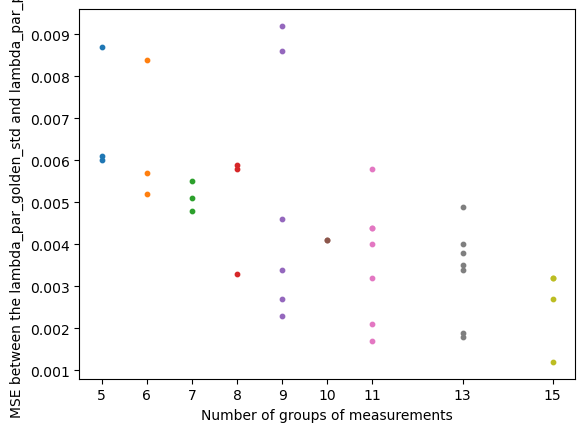

In [46]:
sub_5g = [0.0060, 0.0061,0.0087]
sub_6g = [0.0057,0.0052,0.0084]
sub_7g = [0.0048, 0.0051, 0.0055]
sub_8g = [0.0059, 0.0033, 0.0058]
sub_9g = [0.0023, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]
sub_10g = [0.0041, 0.0041]
sub_11g = [0.0017, 0.0040,0.0058,0.0044,0.0032,0.0021, 0.0044]
sub_13g = [0.0049,0.0034,0.0038,0.0035,0.0040,0.0019,0.0018]
sub_15g = [0.0032,0.0032,0.0012,0.0027]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10)
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_par_golden_std and lambda_par_pred')

ax.set_xticks(x_values)
# ax.set_ylim([0, 0.045])

# calculate and plot mean and variance for each group
# means = [np.mean(y) for y in y_values]
# variances = [np.var(y) for y in y_values]
# print(variances)

# ax.plot(x_values, means, '-o', label='Mean')
# ax.plot(x_values, variances, '-o', label='Variance')

# ax.legend()

# plt.show()

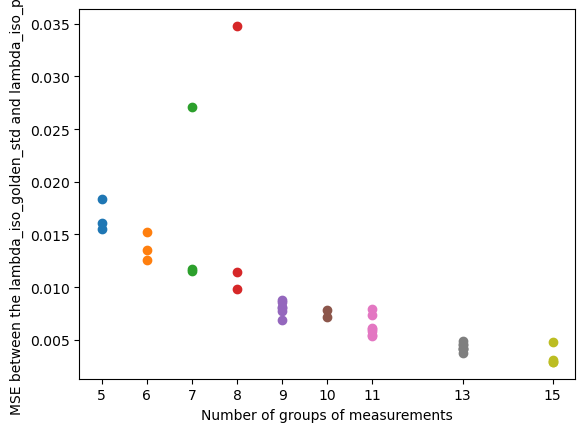

In [47]:
sub_5g = [0.0184, 0.0161,0.0155]
sub_6g = [0.0152,0.0135,0.0126]
sub_7g = [0.0117, 0.0115, 0.0271]
sub_8g = [0.0348, 0.0114, 0.0098]
sub_9g = [0.0086, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]
sub_10g = [0.0072, 0.0078]
sub_11g = [0.0058, 0.0055,0.0060,0.0079,0.0074,0.0054, 0.0061]
sub_13g = [0.0042, 0.0041, 0.0046,0.0049,0.0045,0.0041,0.0037]
sub_15g = [0.0029,0.0048,0.0031,0.0029]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the lambda_iso_golden_std and lambda_iso_pred')

ax.set_xticks(x_values)

# calculate and plot mean and variance for each group
# means = [np.mean(y) for y in y_values]
# variances = [np.var(y) for y in y_values]
# print(variances)

# ax.plot(x_values, means, '-o', label='Mean')
# ax.plot(x_values, variances, '-o', label='Variance')

# ax.legend()

# plt.show()

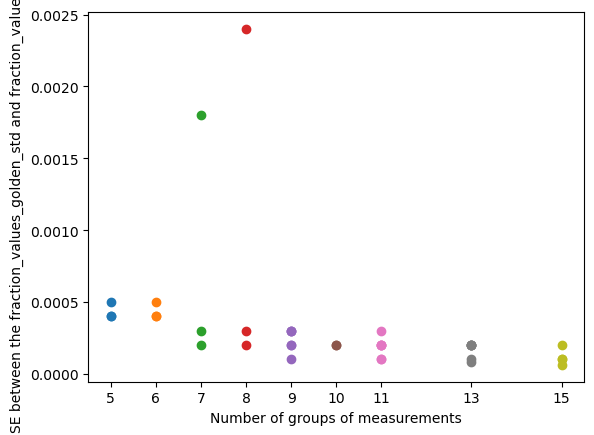

In [48]:
sub_5g = [0.0004,0.0004,0.0005]
sub_6g = [0.0004,0.0004,0.0005]
sub_7g = [0.0003, 0.0002, 0.0018]
sub_8g = [0.0024, 0.0002, 0.0003]
sub_9g = [0.0001, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]
sub_10g = [0.0002, 0.0002]
sub_11g = [0.0001, 0.0002,0.0003,0.0002,0.0002,0.0001, 0.0002]
sub_13g = [0.0002, 0.0002, 0.0002,0.0002,0.0002,8.3640e-05,0.0001]
sub_15g = [0.0001,0.0001,6.2200e-05,0.0002]

x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of measurements')
ax.set_ylabel('MSE between the fraction_values_golden_std and fraction_values_pred')

ax.set_xticks(x_values)

# calculate and plot mean and variance for each group
# means = [np.mean(y) for y in y_values]
# variances = [np.var(y) for y in y_values]
# print(variances)

# ax.plot(x_values, means, '-o', label='Mean')
# ax.plot(x_values, variances, '-o', label='Variance')

# ax.legend()

plt.show()

# means = [np.mean(y) for y in y_values]
# stds = [np.std(y) for y in y_values]
# print(stds)

# fig, ax = plt.subplots()
# for i in range(len(x_values)):
#     ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])

# ax.errorbar(x_values, means, yerr=stds, fmt='o', color='black', capsize=5)

# ax.set_xlabel('Number of groups of measurements')
# ax.set_ylabel('MSE between the fraction_values_golden_std and fraction_values_pred')

# ax.set_xticks(x_values)

# plt.show()

# SSIM and MSE for parameter maps

In [44]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [134]:
def get_ssim_mse(pmap1, pmap2):
    ssim_val = ssim(pmap1, pmap2)
    mse_val = mean_squared_error(pmap1, pmap2)
    return ssim_val, mse_val

In [664]:
print(get_ssim_mse(lambda_par_100307_pred_gstd_3d, lambda_par_100307_pred_3d))
print(get_ssim_mse(lambda_iso_100307_pred_gstd_3d, lambda_iso_100307_pred_3d))
print(get_ssim_mse(volume_0_100307_pred_gstd_3d, volume_0_100307_pred_3d))

(0.9704518254313225, 0.0019367481322465476)
(0.9947703233009024, 0.0015907794079519353)
(0.9963838743834653, 6.589885093913448e-05)


In [665]:
ssim_val_dir_map = ssim(dir_map_gstd, dir, channel_axis=2)
mse_val_dir_map = mean_squared_error(dir_map_gstd, dir)
print(ssim_val_dir_map, mse_val_dir_map)

0.8935498537579761 0.0027325108251645192


* SSIM and MSE for Lambda_par maps

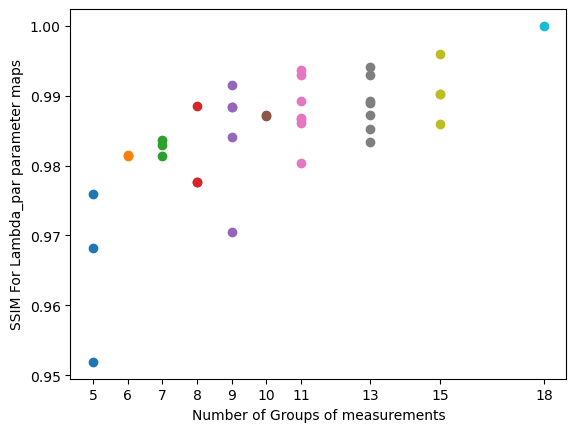

In [666]:
sub_5g = [0.9759776558828824, 0.9518983075840927, 0.9681604925864228]
sub_6g = [0.9815828423988419, 0.9814428560098017]
sub_7g = [0.9830184766670942, 0.9836695575902945, 0.9814134332993826]
sub_8g = [0.977708749991149, 0.98855634844329, 0.9776401493239765]
sub_9g = [0.9915366861790111, 0.9840687373251713,0.9883799184488312, 0.9883739656809384, 0.9704518254313225]
sub_10g = [0.9871846124242878, 0.9870916448737173]
sub_11g = [0.9936738668199634, 0.9868621432868203, 0.9803850431003096, 0.9866942652038659, 0.989311332710161, 0.9930438386914109, 0.98616525150096]
sub_13g = [0.9834123291426734, 0.9892579368323642, 0.9852512676981304, 0.9890045843413818, 0.9873096548566452, 0.9941598034751709, 0.9930453115352653]
sub_15g = [0.9859329063018878, 0.9902492250217612, 0.9959438956137685, 0.990257738711818]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Lambda_par parameter maps')
ax.set_xticks(x_values)



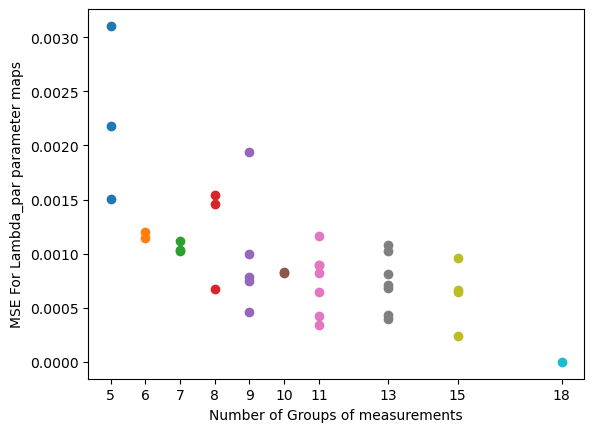

In [717]:
sub_5g = [0.0015004469488090555, 0.003103807365129008, 0.0021796753409998627]
sub_6g = [0.0011441097091476238, 0.001196351951845873]
sub_7g = [0.001036552400296914, 0.001023592036099843, 0.0011152046722088596]
sub_8g = [0.0015428680219389936, 0.0006754114172982294, 0.0014558777758749589]
sub_9g = [0.00046230438031050496, 0.0009980150907870039,0.0007853647712574188, 0.0007478811357140815, 0.0019367481322465476]
sub_10g = [0.0008234449001038391, 0.0008319778759093979]
sub_11g = [0.000342323773253722, 0.000819301775223355, 0.0011651972323278976, 0.0008972381758997132, 0.0006465604789900008, 0.00042338486708403626, 0.0008907981705759358]
sub_13g = [0.001082687912095597, 0.0006867487033802363, 0.0010238830413833635, 0.0007074985244084551, 0.0008135312596682492, 0.0003940008507071108, 0.00043527430599917113]
sub_15g = [0.0009635745345478282, 0.000646753915319165, 0.00023801184880616356, 0.0006657276555355847]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Lambda_par parameter maps')
ax.set_xticks(x_values)


* SSIM and MSE for Lambda_iso maps

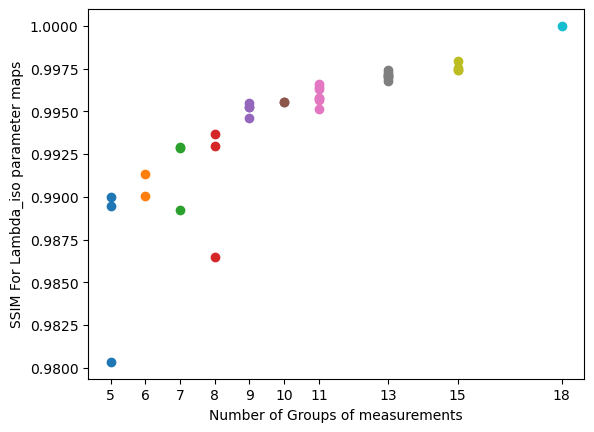

In [648]:
sub_5g = [0.9894336662677689, 0.9803371044226107, 0.9900093307330684]
sub_6g = [0.990020600442737, 0.9913626431744156]
sub_7g = [0.9929426612627144, 0.9928732835984075, 0.9892541526785961]
sub_8g = [0.9865009654150169, 0.9929875514253627, 0.9936515172276236]
sub_9g = [0.9954633431636167, 0.9946015324935225, 0.9952821834256229, 0.9952325592830672, 0.9947703233009024]
sub_10g = [0.995564852676354, 0.9955511137536676]
sub_11g = [0.9964310819729749, 0.9963234487749101, 0.9956704273069564, 0.9951398292643242, 0.995806671999177, 0.9965842605088573, 0.9957775542507356]
sub_13g = [0.9969497075906014,0.997098246656391, 0.9967887218046171, 0.9970974926314625, 0.9971320158367466, 0.9972290087034256, 0.9973974108984194]
sub_15g = [0.9974356464498618, 0.997448101278163, 0.997921500914057, 0.9975565263569428]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Lambda_iso parameter maps')
ax.set_xticks(x_values)



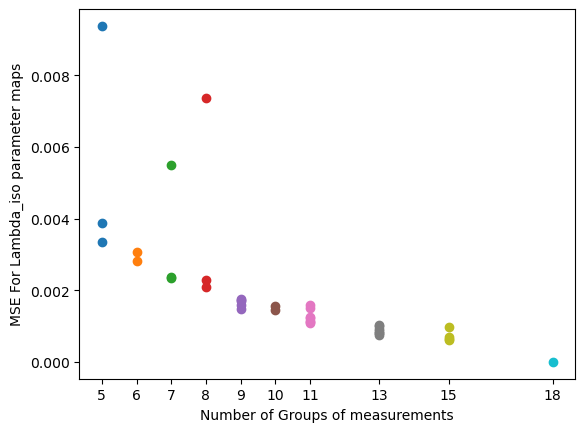

In [718]:
sub_5g = [0.0038780322190904355, 0.009374304979966497, 0.0033418369138758382]
sub_6g = [0.0030666828152001143, 0.0028257120709274516]
sub_7g = [0.0023656906258047597, 0.0023341988009446557, 0.005492777527715979]
sub_8g = [0.007370921164912833, 0.002298740632148711, 0.002079055807592994]
sub_9g = [0.0017466535575937753, 0.001731578240499696, 0.0017075882149832026,0.0014727933495720408, 0.0015907794079519353]
sub_10g = [0.0014524506471521477, 0.001568438828205931]
sub_11g = [0.0011395739986478199, 0.001105913566987152, 0.001225138724782639, 0.001598196993988727, 0.0014988206639575954, 0.0010859694018533188, 0.0012416811372352962]
sub_13g = [0.000876430063480257, 0.0008197611376329894, 0.0010324948374323246, 0.0009913742184068405, 0.0009104269032768368, 0.000819490660109063, 0.0007586437047484404]
sub_15g = [0.0006855365465011624, 0.000965865038185378, 0.0006179210089879208, 0.0006520861018961497]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Lambda_iso parameter maps')
ax.set_xticks(x_values)

* SSIM and MSE for stick_fraction maps

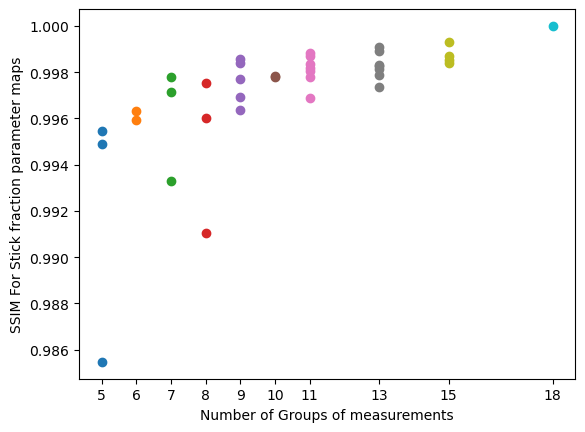

In [674]:
sub_5g = [0.995459535262334, 0.9854696664646769, 0.9948883328110978]
sub_6g = [0.9959236848603096, 0.9963418592258344]
sub_7g = [0.9971444290677269, 0.997774922268137, 0.9933075697084556]
sub_8g = [0.9910482604151682,0.9975339904402777, 0.9960216945046345]
sub_9g = [0.998590481191039, 0.9969118624115217, 0.9983768739529159, 0.9977049416903311, 0.9963838743834653]
sub_10g = [0.9977817589598589, 0.9978343532915239]
sub_11g = [0.9988441075327278, 0.997804879885554, 0.9968706525051317, 0.9983671348620409, 0.9981654353339054, 0.9986891536579993, 0.9980415777820909]
sub_13g = [0.9973654748238636, 0.9981220990753779, 0.9983062334251274, 0.9982782699265627, 0.9978863482054229, 0.9991057302589033, 0.9988944380860967]
sub_15g = [0.9985264335870586, 0.998402468156555, 0.9993073743577967, 0.9987041707875421]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For Stick fraction parameter maps')
ax.set_xticks(x_values)



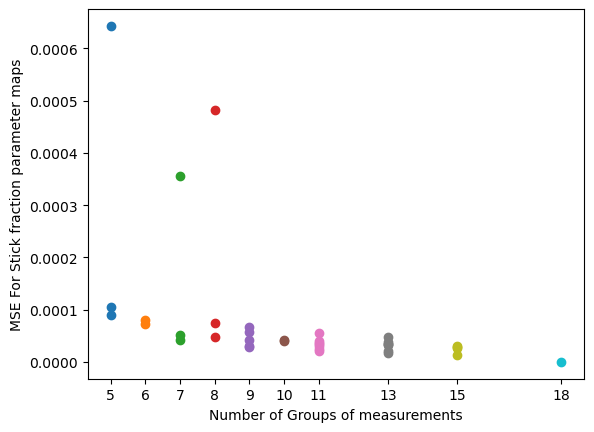

In [675]:
sub_5g = [9.035317460159092e-05, 0.0006432123538906386,  0.0001048247113274267]
sub_6g = [7.964876086339271e-05, 7.301041310919896e-05]
sub_7g = [5.228665809509343e-05, 4.259578124822216e-05, 0.0003566334706733673]
sub_8g = [0.0004825227263713608, 4.686233600642654e-05,7.411586890237598e-05]
sub_9g = [2.776975234773326e-05, 5.780381521054784e-05, 3.1066685087672e-05, 4.274249320682423e-05, 6.589885093913448e-05]
sub_10g = [4.128559018058594e-05, 4.063398886946314e-05]
sub_11g = [2.183805800865263e-05, 3.971804585618461e-05, 5.5226659339894005e-05, 3.084999861246646e-05, 3.3550626631021705e-05, 2.4933112929731393e-05, 3.626071712685962e-05]
sub_13g = [4.774445345753439e-05, 3.4308436684075874e-05, 3.403398347625411e-05, 3.156225745711012e-05, 3.8787306948945e-05, 1.692181862086043e-05, 2.091950103100162e-05]
sub_15g = [3.1289927853903544e-05, 2.8398962013827765e-05, 1.2584175737511735e-05, 2.738806771143417e-05]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For Stick fraction parameter maps')
ax.set_xticks(x_values)



* SSIM and MSE for angle dirction maps

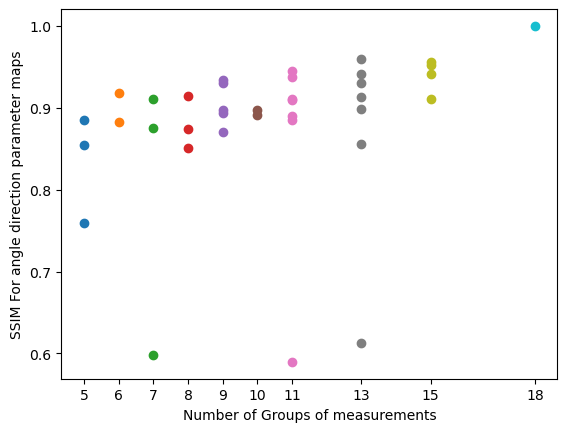

In [676]:
sub_5g = [0.8545556472545212, 0.7590823558411675, 0.8848941475516869]
sub_6g = [0.8826785343183142, 0.9175569832897982]
sub_7g = [0.8747973393367316, 0.9111473368314199, 0.5987216106705319]
sub_8g = [0.873565541007722, 0.9147578348921672, 0.851067472658397]
sub_9g = [0.9304429306142891, 0.8701097240515328, 0.9343306343228542,0.8968269696213284,0.8935498537579761]
sub_10g = [0.8911490650724301, 0.8972623776938198]
sub_11g = [0.9375096041024601, 0.885376194111954, 0.5896994539555892, 0.9099917909187015, 0.9104970829659201, 0.9452144443727436, 0.8902316893129368]
sub_13g = [0.8562511792036996, 0.8990500274483756, 0.9306270228808508, 0.9132387559589984, 0.6123796315011288, 0.9597451981695192, 0.941843444477716]
sub_15g = [0.9409474919312046, 0.9107949932149673, 0.9562030887248917,0.9523129512461296]
sub_18g = [1.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('SSIM For angle direction parameter maps')
ax.set_xticks(x_values)


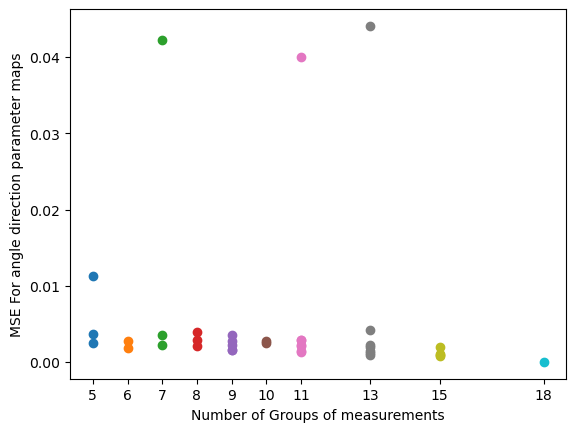

In [701]:
sub_5g = [0.003711164777781138, 0.011331411439759048, 0.0024913373000128984]
sub_6g = [0.002779022447489647, 0.0018882057498250356]
sub_7g = [0.003490942895590238, 0.0022202393078372836, 0.042209352621237976]
sub_8g = [0.002841221147201351, 0.002096287277636201, 0.0038768486782062464]
sub_9g = [0.0016253811334667973, 0.0035096288864162415, 0.0015951197946020626, 0.0022552130581891153,0.0027325108251645192]
sub_10g = [0.002721350909338698, 0.002476677971851721]
sub_11g = [0.0013748133720775367,  0.0029200378535124043, 0.04002114438967472, 0.0020301378564268092, 0.002173126466294961, 0.0012388192405793494, 0.0029363048611570804]
sub_13g = [0.00416823447426363, 0.0021686090108145963, 0.0013955068260538069, 0.001949367483680303, 0.044088633872010355, 0.0008926219500614515, 0.0011095881111700572]
sub_15g = [0.001019844497138992, 0.0019440547291586028, 0.0008049514512604328, 0.0008880948576550622]
sub_18g = [0.]
x_values = [5, 6, 7, 8, 9, 10, 11, 13, 15, 18]
y_values = [sub_5g, sub_6g, sub_7g, sub_8g, sub_9g, sub_10g, sub_11g, sub_13g, sub_15g, sub_18g]
fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of Groups of measurements')
ax.set_ylabel('MSE For angle direction parameter maps')
ax.set_xticks(x_values)